In [1]:
import numpy as np
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes option price.

    Parameters:
    S (float): Current stock price
    K (float): Option strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annual)
    sigma (float): Volatility of the underlying stock (annual)
    option_type (str): 'call' for call option, 'put' for put option

    Returns:
    float: Black-Scholes price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# Example usage
S = 75  # Current stock price
K = 50  # Option strike price
T = 1    # Time to maturity (1 year)
r = 0.05 # Risk-free interest rate (5%)
sigma = 0.2 # Volatility (20%)

call_price = black_scholes(S, K, T, r, sigma, option_type='call')
put_price = black_scholes(S, K, T, r, sigma, option_type='put')

print(f"Call Option Price: {call_price}")
print(f"Put Option Price: {put_price}")

Call Option Price: 27.485070068999597
Put Option Price: 0.04654129403529883


## Implicit

In [3]:
class ImplicitPDESolver:
    def __init__(self, config: dict):
        self.solved = False
        self.config = config
        self.term = np.max(config['t'])
        self.strike = config['strike']
        self.r = config['r']
        self.sigma = config['sigma']
        
        self.t, self.x = np.meshgrid(self.config['t'], self.config['x'])

        self.grid = np.zeros(self.x.shape)
        self.grid[0, :] = 0
        self.grid[-1, :] = np.maximum(self.x[-1, :] - np.exp(-self.r * (np.max(self.term) - self.t[-1, :])) * self.strike, 0)
        self.grid[:, -1] = np.maximum(self.x[:, -1] - self.strike, 0)

    def solve(self):
        if self.solved:
            print("Already solved")
            return None
        dt = self.config['t'][1] - self.config['t'][0]

        calc_A = True
        A = np.zeros((self.config['x'].shape[0], self.config['x'].shape[0]))
        b = np.zeros((self.config['x'].shape[0] - 2,)).reshape(-1, 1)


        for i in range(-2, -self.t.shape[1] - 1, -1):
            # start_time = time.perf_counter()  # Start timing
            if calc_A:
                for j in range(1, self.x.shape[0] - 1):
                    a_j = 0.5 * self.r * j * dt - 0.5 * self.sigma**2 * j**2 * dt
                    b_j = 1 + self.sigma**2 * j**2 * dt + self.r * dt
                    c_j = -0.5 * self.r * j * dt - 0.5 * self.sigma**2 * j**2 * dt
                    
                    A[j, j - 1] = a_j
                    A[j, j] = b_j
                    A[j, j + 1] = c_j
                a_1 = A[1, 0]
                c_m_1 = A[-2, -1]
                A = A[1:-1, 1:-1]
                A_inv = np.linalg.inv(A)
            b = self.grid[1:-1, i + 1].copy()

            b[0] -= a_1 * self.grid[0, i]
            b[-1] -= c_m_1 * self.grid[-1, i]
            self.grid[1:-1, i] = (A_inv @ b).flatten()

            calc_A = False
            # end_time = time.perf_counter()
            # elapsed_time = end_time - start_time
            # print(f"Solve method {-i - 1} loop execution time: {elapsed_time:.6f} seconds")
        self.solved = True



## Crank-Nicolson

In [4]:
class CrankNicolsonPDESolver:
    def __init__(self, config: dict):
        self.solved = False
        self.config = config
        self.term = np.max(config['t'])
        self.strike = config['strike']
        self.r = config['r']
        self.sigma = config['sigma']
        
        self.t, self.x = np.meshgrid(self.config['t'], self.config['x'])

        self.grid = np.zeros(self.x.shape)
        self.grid[0, :] = 0
        self.grid[-1, :] = np.maximum(self.x[-1, :] - np.exp(-self.r * (np.max(self.term) - self.t[-1, :])) * self.strike, 0)
        self.grid[:, -1] = np.maximum(self.x[:, -1] - self.strike, 0)

    def solve(self):
        if self.solved:
            print("Already solved")
            return None
        dt = self.config['t'][1] - self.config['t'][0]

        calc_A = True
        left_A = np.zeros((self.config['x'].shape[0], self.config['x'].shape[0]))
        right_A = np.zeros((self.config['x'].shape[0], self.config['x'].shape[0]))


        for i in range(-2, -self.t.shape[1] - 1, -1):
            # start_time = time.perf_counter()  # Start timing
            if calc_A:
                for j in range(1, self.x.shape[0] - 1):
                    a_j = 0.25 * dt * (self.sigma**2 * j**2 - self.r * j)
                    b_j = -0.5 * dt * (self.sigma**2 * j**2 + self.r)
                    c_j = 0.25 * dt * (self.sigma**2 * j**2 + self.r * j)
                    
                    left_A[j, j - 1] = -a_j
                    left_A[j, j] = 1 - b_j
                    left_A[j, j + 1] = -c_j

                    right_A[j, j - 1] = a_j
                    right_A[j, j] = 1 + b_j
                    right_A[j, j + 1] = c_j
                a_1 = right_A[1, 0]
                c_m_1 = right_A[-2, -1]
                left_A = left_A[1:-1, 1:-1]
                right_A = right_A[1:-1, 1:-1]
                A_inv = np.linalg.inv(left_A)
            
            b = right_A  @ self.grid[1:-1, i + 1].copy().reshape(-1, 1)

            b[0] += a_1 * (self.grid[0, i] + self.grid[0, i + 1])
            b[-1] += c_m_1 * (self.grid[-1, i] + self.grid[-1, i + 1])
            self.grid[1:-1, i] = (A_inv @ b).flatten()

            calc_A = False
            # end_time = time.perf_counter()
            # elapsed_time = end_time - start_time
            # print(f"Solve method {-i - 1} loop execution time: {elapsed_time:.6f} seconds")
        self.solved = True



### General solve function

In [5]:
def solve(base_cls):
    dt = base_cls.config['t'][1] - base_cls.config['t'][0]

    calc_A = True
    left_A = np.zeros((base_cls.config['x'].shape[0], base_cls.config['x'].shape[0]))
    right_A = np.zeros((base_cls.config['x'].shape[0], base_cls.config['x'].shape[0]))


    for i in range(-2, -base_cls.t.shape[1] - 1, -1):
        if calc_A:
            for j in range(1, base_cls.x.shape[0] - 1):
                a_j = 0.25 * dt * (base_cls.sigma**2 * j**2 - base_cls.r * j)
                b_j = -0.5 * dt * (base_cls.sigma**2 * j**2 + base_cls.r)
                c_j = 0.25 * dt * (base_cls.sigma**2 * j**2 + base_cls.r * j)
                
                left_A[j, j - 1] = -a_j
                left_A[j, j] = 1 - b_j
                left_A[j, j + 1] = -c_j

                right_A[j, j - 1] = a_j
                right_A[j, j] = 1 + b_j
                right_A[j, j + 1] = c_j
            a_1 = right_A[1, 0]
            c_m_1 = right_A[-2, -1]
            left_A = left_A[1:-1, 1:-1]
            right_A = right_A[1:-1, 1:-1]
            A_inv = np.linalg.inv(left_A)
        
        b = right_A  @ base_cls.grid[1:-1, i + 1].copy().reshape(-1, 1)

        b[0] += a_1 * (base_cls.grid[0, i] + base_cls.grid[0, i + 1])
        b[-1] += c_m_1 * (base_cls.grid[-1, i] + base_cls.grid[-1, i + 1])
        base_cls.grid[1:-1, i] = (A_inv @ b).flatten()

        calc_A = False

### TensorFlow tf.function

In [6]:
class TensorFlowCrankNicolsonPDESolver:
    def __init__(self, config: dict):
        self.config = config
        self.term = np.max(config['t'])
        self.strike = config['strike']
        self.r = config['r']
        self.sigma = config['sigma']
        
        self.t, self.x = np.meshgrid(self.config['t'], self.config['x'])

        self.grid = np.zeros(self.x.shape)
        self.grid[0, :] = 0
        self.grid[-1, :] = np.maximum(self.x[-1, :] - np.exp(-self.r * (np.max(self.term) - self.t[-1, :])) * self.strike, 0)
        self.grid[:, -1] = np.maximum(self.x[:, -1] - self.strike, 0)
        self.grid = tf.Variable(self.grid, dtype=tf.float64)

        self.calc_A = tf.constant(True)
        self.left_A = tf.Variable(tf.zeros((self.config['x'].shape[0], self.config['x'].shape[0]), dtype=tf.float64))
        self.right_A = tf.Variable(tf.zeros((self.config['x'].shape[0], self.config['x'].shape[0]), dtype=tf.float64))
        self.A_inv = tf.Variable(tf.zeros((self.config['x'].shape[0] - 2, self.config['x'].shape[0] - 2), dtype=tf.float64))
        self.a_1 = tf.Variable(0.0, dtype=tf.float64)
        self.c_m_1 = tf.Variable(0.0, dtype=tf.float64)

@tf.function
def solve_as_graph(base_cls):
    dt = tf.gather(base_cls.config['t'], 1) - tf.gather(base_cls.config['t'], 0)
    print("Retrace")
    for i in tf.range(-2, -base_cls.t.shape[1] - 1, -1):
        if base_cls.calc_A:
            for j in tf.range(1, base_cls.x.shape[0] - 1):
                a_j = tf.constant(0.25, dtype=tf.float64) * dt * (base_cls.sigma**2 * tf.cast(j, tf.float64)**2 - base_cls.r * tf.cast(j, tf.float64))
                b_j = tf.constant(-0.5, dtype=tf.float64) * dt * (base_cls.sigma**2 * tf.cast(j, tf.float64)**2 + base_cls.r)
                c_j = tf.constant(0.25, dtype=tf.float64) * dt * (base_cls.sigma**2 * tf.cast(j, tf.float64)**2 + base_cls.r * tf.cast(j, tf.float64))
                
                base_cls.left_A = tf.tensor_scatter_nd_update(base_cls.left_A, [[j, j - 1]], [-a_j])
                base_cls.left_A = tf.tensor_scatter_nd_update(base_cls.left_A, [[j, j]], [1 - b_j])
                base_cls.left_A = tf.tensor_scatter_nd_update(base_cls.left_A, [[j, j + 1]], [-c_j])
                base_cls.right_A = tf.tensor_scatter_nd_update(base_cls.right_A, [[j, j - 1]], [a_j])
                base_cls.right_A = tf.tensor_scatter_nd_update(base_cls.right_A, [[j, j]], [1 + b_j])
                base_cls.right_A = tf.tensor_scatter_nd_update(base_cls.right_A, [[j, j + 1]], [c_j])
            
            base_cls.a_1.assign(base_cls.right_A[1, 0])
            base_cls.c_m_1.assign(base_cls.right_A[-2, -1])
            base_cls.A_inv.assign(tf.linalg.inv(base_cls.left_A[1:-1, 1:-1]))
        
        base_cls.calc_A = tf.constant(False)
        b = tf.matmul(base_cls.right_A[1:-1, 1:-1], tf.reshape(base_cls.grid[1:-1, i + 1], [-1, 1]))
        b = tf.tensor_scatter_nd_add(b, [[0]], [[base_cls.a_1 * (base_cls.grid[0, i] + base_cls.grid[0, i + 1])]])
        b = tf.tensor_scatter_nd_add(b, [[tf.shape(b)[0] - 1]], [[base_cls.c_m_1 * (base_cls.grid[-1, i] + base_cls.grid[-1, i + 1])]])
        base_cls.grid[1:-1, i].assign(tf.squeeze(tf.matmul(base_cls.A_inv, b)))

config = {
    't': tf.constant(np.linspace(0, 1, 100 + 1), dtype=tf.float64),
    'x': tf.constant(np.linspace(0, 1, 100 + 1), dtype=tf.float64),
    'strike': tf.constant(50, dtype=tf.float64),
    'r': tf.constant(0.05, dtype=tf.float64),
    'sigma': tf.constant(0.2, dtype=tf.float64)
}

tf.config.run_functions_eagerly(False)
solver = TensorFlowCrankNicolsonPDESolver(config)
solve_as_graph(solver)

Retrace


In [7]:
import timeit

run_config = {'t': np.linspace(0, 1, 300+1), 'x': np.linspace(0, 100, 100+1),
              'strike': 50, 'r': 0.05,
              'sigma': 0.2}
solver = CrankNicolsonPDESolver(run_config)

print("Python execution:", timeit.timeit(lambda: solve(solver), number=20), "seconds")

config = {
    't': tf.constant(np.linspace(0, 1, 300 + 1), dtype=tf.float64),
    'x': tf.constant(np.linspace(0, 100, 100 + 1), dtype=tf.float64),
    'strike': tf.constant(50, dtype=tf.float64),
    'r': tf.constant(0.05, dtype=tf.float64),
    'sigma': tf.constant(0.2, dtype=tf.float64)
}
solver = TensorFlowCrankNicolsonPDESolver(config)
print("Tensorflow execution:", timeit.timeit(lambda: solve_as_graph(solver), number=20), "seconds")

Python execution: 4.09705009998288 seconds
Retrace
Tensorflow execution: 3.075807600049302 seconds


## Plots

In [8]:
run_config = {'t': np.linspace(0, 0.1, 1000+1), 'x': np.linspace(0, 200, 200+1),
              'strike': 120, 'r': 0.02,
              'sigma': 0.25}

call_I = ImplicitPDESolver(config=run_config)
call_I.solve()

call_CN = CrankNicolsonPDESolver(config=run_config)
call_CN.solve()

C:\Users\Kristof\AppData\Local\Temp\ipykernel_18520\977416094.py:16: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


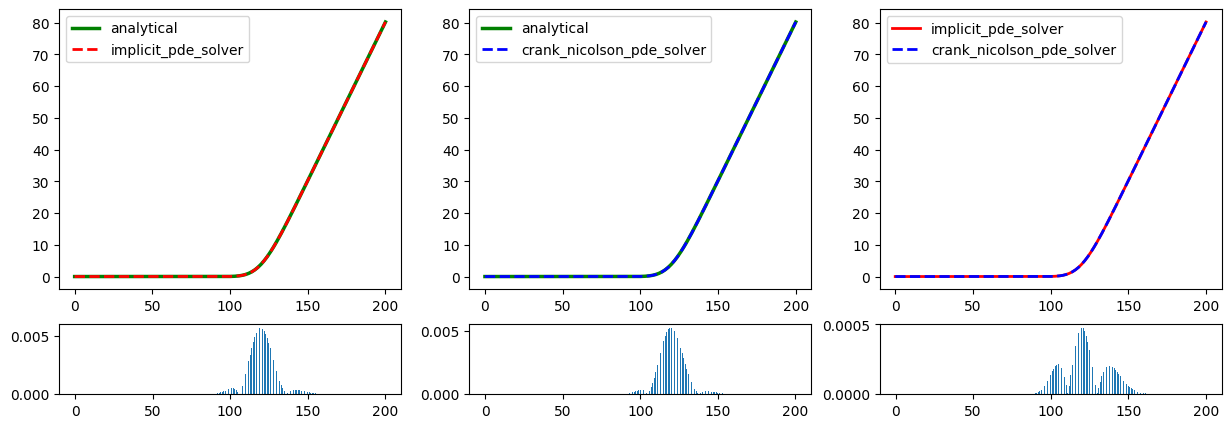

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5), gridspec_kw={'height_ratios': [4, 1]})

slice = 0

formula_solution = black_scholes(run_config['x'],
                                 run_config['strike'],
                                 np.max(run_config['t']) - run_config['t'][slice],
                                 run_config['r'],
                                 run_config['sigma'],
                                 option_type='call')

ax[0][0].plot(run_config['x'], formula_solution, lw=2.5, color="green", label='analytical')
ax[0][0].plot(run_config['x'], call_I.grid[:, slice], linestyle='dashed', lw=2, color="red", label='implicit_pde_solver')
ax[0][0].legend()
ax[1][0].bar(run_config['x'], np.abs(call_I.grid[:, slice] - formula_solution), width=0.5)

ax[0][1].plot(run_config['x'], formula_solution, lw=2.5, color="green", label='analytical')
ax[0][1].plot(run_config['x'], call_CN.grid[:, slice], linestyle='dashed', lw=2, color="blue", label='crank_nicolson_pde_solver')
ax[0][1].legend()
ax[1][1].bar(run_config['x'], np.abs(call_CN.grid[:, slice] - formula_solution), width=0.5)

ax[0][2].plot(run_config['x'], call_I.grid[:, slice], linestyle='solid', lw=2, color="red", label='implicit_pde_solver')
ax[0][2].plot(run_config['x'], call_CN.grid[:, slice], linestyle='dashed', lw=2, color="blue", label='crank_nicolson_pde_solver')
ax[0][2].legend()
ax[1][2].bar(run_config['x'], np.abs(call_CN.grid[:, slice] - call_I.grid[:, slice]), width=0.5)

plt.show()